# Identify Factors That Influence Corruption With The Use Of Machine Learning

**Authors:** Renaud Kilian

**Overview:** This project aims to identify and understand the various socio-economic and political factors influencing the Corruption Perceptions Index (CPI) at a country level. The exploration of these potential indicators might provide valuable insights into developing effective strategies to mitigate corruption and promote transparency and accountability in public sectors globally.

**Appaoach:** The project is following a CRISP-DM approach. split between this notebook and the README.md file. The README.md file contains the Business Understanding, and deployment. This notebook contains the data understanding, data preparation, and modeling phases.



## Data Understanding and Preparation

**Exploratory Data Analysis (EDA) Approach**

The goal of our EDA is to understand the characteristics, patterns, and potential anomalies in our datasets (CPI and WDI). 

### Data Sources

The necessary data will be sourced from the following:

1. [Corruption Perceptions Index (CPI)](https://www.transparency.org/en/cpi) - Transparency International
2. [World Development Indicators (WDI)](https://databank.worldbank.org/source/world-development-indicators) - World Bank's Open Data


In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import imageio.v2 as imageio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.inspection import permutation_importance

# disable warnings
import warnings
warnings.filterwarnings('ignore')

### Corruption Perceptions Index (CPI) by Transparency International

- **Data Source:** [Transparency International's CPI](https://www.transparency.org/en/cpi).
- **Description:** The CPI is a composite index that ranks countries and territories based on their public sector's perceived corruption levels. The index is formed from a combination of surveys and corruption assessments sourced from various respected institutions, making it globally recognized as a leading corruption indicator. The index is scored on a scale of 0 (highly corrupt) to 100 (very clean).
- **Limitations:** The CPI is perception-based and does not directly measure corruption levels. Instead, it compiles data from different sources, capturing the views of business people and country experts on the public sector's corruption levels. As such, the CPI should not be viewed as a definitive judgment of a society's overall corruption levels but as an evaluation of public sector corruption.
- **Collection Methodology:** The CPI is derived from 13 surveys and assessments from 12 independent institutions. These sources typically define corruption as "the misuse of public power for private benefit." A country must have at least three data sources available for a given year to receive a CPI score.
- **Update Frequency:** Transparency International publishes the CPI annually.
- **Use Note:** CPI scores prior to 2012 are not directly comparable with scores from subsequent years due to methodology changes. Thus, these scores will not be utilized in our analysis.


In [2]:
# Fetch the Transparency International CPI data from local file
# https://www.transparency.org/en/cpi/2022

CPI = pd.read_csv('data/CPI2022_GlobalResultsTrends.csv', header=0)

display(CPI.head())
display(CPI.tail())
display(CPI.info())

,Country / Territory,ISO3,Region,Year,CPI score,Rank,Sources,Standard error
0,Afghanistan,AFG,AP,2012,8,NaN,3,3.30
1,Afghanistan,AFG,AP,2013,8,NaN,3,3.30
2,Afghanistan,AFG,AP,2014,12,NaN,4,1.29
3,Afghanistan,AFG,AP,2015,11,NaN,4,3.49
4,Afghanistan,AFG,AP,2016,15,NaN,5,1.74


,Country / Territory,ISO3,Region,Year,CPI score,Rank,Sources,Standard error
1944,Zimbabwe,ZWE,SSA,2018,22,160.0,9,2.290000
1945,Zimbabwe,ZWE,SSA,2019,24,158.0,9,2.307745
1946,Zimbabwe,ZWE,SSA,2020,24,157.0,9,1.352586
1947,Zimbabwe,ZWE,SSA,2021,23,157.0,8,1.518090
1948,Zimbabwe,ZWE,SSA,2022,23,157.0,8,1.532080


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1949 entries, 0 to 1948
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country / Territory  1949 non-null   object 
 1   ISO3                 1949 non-null   object 
 2   Region               1949 non-null   object 
 3   Year                 1949 non-null   int64  
 4   CPI score            1949 non-null   int64  
 5   Rank                 1080 non-null   float64
 6   Sources              1949 non-null   int64  
 7   Standard error       1949 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 121.9+ KB


None

##### Selecting relevant data for our analysis:
For this project, we will only use the CPI scores from 2012 to 2020. We will also drop the `Rank`, `Standard Error`, and `Number of Sources` columns since they are not relevant for our analysis.

In [3]:
# drop columns that are not needed
CPI.drop(['Rank', 'Sources', 'Standard error'], axis=1, inplace=True)

##### Checking for duplicate or missing values and deciding on the imputation strategy if required.

In [4]:
# Check for missing values per feature
print(f'Missing value: \n{CPI.isnull().sum()}')

# Check for duplicate rows
print(f'Duplicate rows: {CPI.duplicated().sum()}')

Missing value: 
Country / Territory    0
ISO3                   0
Region                 0
Year                   0
CPI score              0
dtype: int64
Duplicate rows: 0


##### Check completness each year (from 2012 to 2022) is available for each country 

In [5]:
# Create a dataframe with all possible combinations of ISO3 and Year
all_countries = CPI['ISO3'].unique()
all_years = np.arange(2012, 2023)  # adjust the years as needed

# Merge with original dataframe to include all CPI scores
df_full = pd.merge(pd.DataFrame(index=pd.MultiIndex.from_product([all_countries, all_years], names=['ISO3', 'Year'])).reset_index(), 
                   CPI, on=['ISO3', 'Year'], how='left')

# df_full[df_full['CPI score'].isnull()][['ISO3', 'Year']].groupby('ISO3').count()
fullMatrix = df_full.pivot(index='ISO3', columns='Year', values='CPI score')

# display fullMatrix rows where at least one value is missing
display(fullMatrix[fullMatrix.isnull().any(axis=1)])

Year,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
ISO3,,,,,,,,,,,
BHS,71.0,71.0,71.0,NaN,66.0,65.0,65.0,64.0,63.0,64.0,64.0
BRB,76.0,75.0,74.0,NaN,61.0,68.0,68.0,62.0,64.0,65.0,65.0
BRN,55.0,60.0,NaN,NaN,58.0,62.0,63.0,60.0,60.0,NaN,NaN
DMA,58.0,58.0,58.0,NaN,59.0,57.0,57.0,55.0,55.0,55.0,55.0
FJI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,53.0
GNQ,20.0,19.0,NaN,NaN,NaN,17.0,16.0,16.0,16.0,17.0,17.0
GRD,NaN,NaN,NaN,NaN,56.0,52.0,52.0,53.0,53.0,53.0,52.0
LCA,71.0,71.0,71.0,NaN,60.0,55.0,55.0,55.0,56.0,56.0,55.0
MDV,NaN,NaN,NaN,NaN,36.0,33.0,31.0,29.0,43.0,40.0,40.0


- Fidji is missing most of its values (9 years out of 11). We will drop this country from our analysis.
- Every other country has data for at least the last 6 years.

In [6]:
# drop Fiji related records
CPI.drop(CPI[CPI['ISO3'] == 'FJI'].index, inplace=True)
df_full.drop(df_full[df_full['ISO3'] == 'FJI'].index, inplace=True)

##### Checking consistency of ISO codes and country names across datasets.


In [7]:
print(CPI[['ISO3','Country / Territory']].nunique())
print(CPI.groupby(['ISO3','Country / Territory']).count().shape)

ISO3                   180
Country / Territory    180
dtype: int64
(180, 3)


- `ISO3` and `Country` columns are matching 1 to 1. We will keep the `Country / Territory` only for description. However, we will not use it for our analysis and we will use the `ISO3` code as index for analysis and to merge our datasets.

##### Analyse Distribution and Check for outliers 

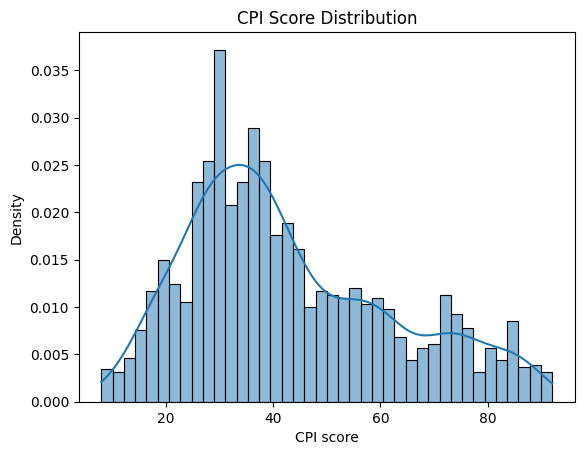

,Year,CPI score
count,1947.000000,1947.000000
mean,2017.040062,43.023112
std,3.162349,19.277547
min,2012.000000,8.000000
25%,2014.000000,29.000000
50%,2017.000000,38.000000
75%,2020.000000,56.000000
max,2022.000000,92.000000


In [8]:
sns.histplot(data=CPI, x='CPI score', kde=True, bins=40, stat="density")
plt.title('CPI Score Distribution')
plt.show()

display(CPI.describe())

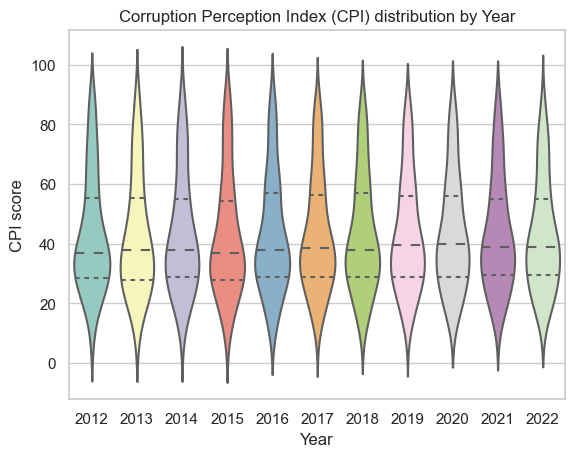

In [9]:
# Draw Corruption Perception Index (CPI) distribution
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x="Year", y="CPI score", data=CPI, palette="Set3", inner="quartile")
plt.title('Corruption Perception Index (CPI) distribution by Year')
plt.show()

- The CPI is scored on a scale of 0 (highly corrupt) to 100 (very clean). The distribution of the CPI scores is skewed to the left, with a mean of 43. The minimum score is 8, and the maximum score is 92.
- Distribution of CPI is similar across years.
- There are no outliers in the CPI dataset.

##### Distribution by Region

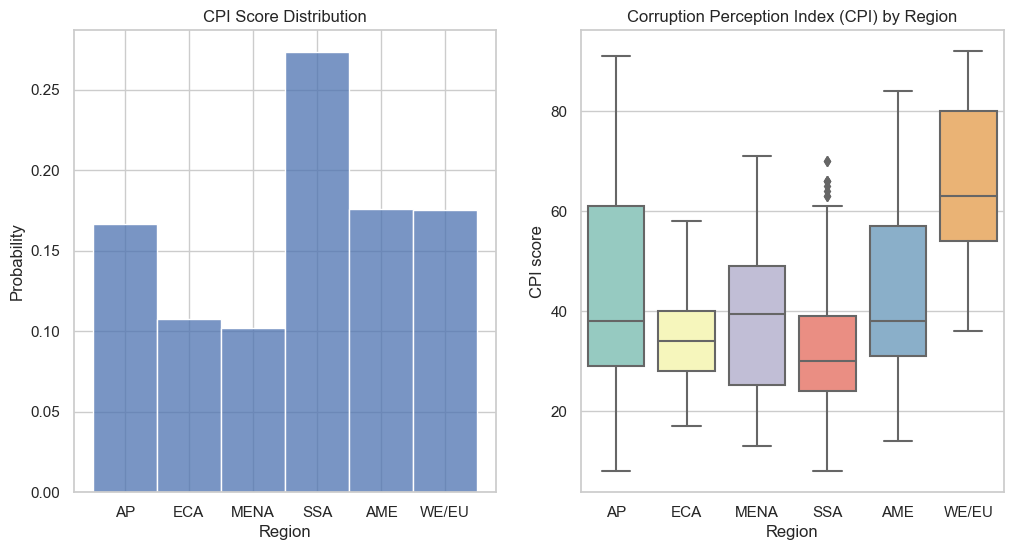

In [10]:
# Create a grid of subplots with 1 row and 2 columns
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the histogram in the first subplot
sns.histplot(data=CPI, x='Region', kde=False, bins=40, stat="probability", ax=axs[0])
axs[0].set_title('CPI Score Distribution')

# Plot the boxplot in the second subplot
sns.boxplot(x="Region", y="CPI score", data=CPI, palette="Set3", ax=axs[1])
axs[1].set_title('Corruption Perception Index (CPI) by Region')

# Display the figure
plt.show()

- `Region` could be relevant for our analysis. However, the information is also available in the World Bank dataset. As it is widely used by international institutions, we will use the `Region` information from World Bank.

##### CPI world map

In [12]:
# draw animated colopeth map of CPI score by country over time
fig = px.choropleth(CPI, locations="ISO3", color="CPI score", hover_name="Country / Territory", animation_frame="Year",
                    color_continuous_scale=px.colors.sequential.Darkmint
                    , range_color=[0, 100]
                    , title="Corruption Perception Index (CPI) by Country 2012-2022"
                    , width=800, height=520)
fig.update_layout(margin={"l": 10,"r": 10, "t": 40,  "b": 1})
fig.add_annotation(x=1, y=-0.08, xref='paper', yref='paper', text='Source:<a href="https://www.transparency.org/en/cpi/2022">Transparency International</a>', showarrow=False)

fig.show()

In [48]:
##### Generate map gif for Readme.md #####

# Years to include in the animation
years = range(2012, 2023)

# File paths for the images and final GIF
image_file_paths = [f'images/map_{year}.png' for year in years]
gif_file_path = 'images/animated_map.gif'

# Create an image for each year
for year, file_path in zip(years, image_file_paths):
    df_year = CPI[CPI['Year'] == year]
    fig = px.choropleth(df_year, locations="ISO3", color="CPI score", hover_name="Country / Territory",
                        color_continuous_scale=px.colors.sequential.Darkmint, range_color=[0, 100],
                        title="Corruption Perception Index (CPI) - 2012-2022", width=1600, height=840
                        )
    # title position and font size
    fig.update_layout(title_x=0.5, title_font_size=24, title_y=0.98)
    
    fig.update_layout(margin={"l": 10,"r": 10, "t": 30,  "b": 1})
    fig.add_annotation(x=1, y=0, xref='paper', yref='paper', text='Source:<a href="https://www.transparency.org/en/cpi/2022">Transparency International</a>', showarrow=False, font_size=20)
    fig.add_annotation(x=0, y=0, xref='paper', yref='paper', text='Year: {}'.format(year), showarrow=False, font_size=20)
    
    pio.write_image(fig, file_path)

# Create a GIF from the images
images = [imageio.imread(file_path) for file_path in image_file_paths]
imageio.mimsave(gif_file_path, images, duration=500, loop=0)

### World Bank Indicators - World Bank's Open Data

- **Data Source:** [World Bank's Open Data](https://databank.worldbank.org/source/world-development-indicators)
- **Description:** The World Bank Indicators encompass a wide range of economic, social, and environmental data about World Bank member countries and other economies. These indicators include metrics like GDP, education, health, labor, trade, and numerous others, offering comprehensive insights into various development aspects globally. Each indicator has a specific scale relevant to the data it presents. The dataset provided for this analysis contains 1,478 indicators addressing over 90 topics.
- **Limitations:** While these indicators offer valuable insights, they come with certain limitations, including varying data quality across countries, potential errors due to statistical estimation techniques, and some data being outdated or missing for certain countries or years.
- **Collection Methodology:** The World Bank sources data from various national and international sources, including statistical publications and databases maintained by countries, UN agencies, various international and regional organizations, and academic sources. The data undergoes rigorous quality checks before being made available on the platform.
- **Update Frequency:** The World Bank continuously updates its datasets as fresh data becomes available, though the frequency can vary depending on the data source and indicator.


In [14]:
# Read csv from zip file
WDI = pd.read_csv('data/WDIData.zip')

display(WDI.head(5))
display(WDI['Indicator Name'].unique().shape)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.196986,17.597176,18.034249,18.345878,18.695306,19.149942,19.501837,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,6.580066,6.786218,6.941323,7.096843,7.254828,7.460783,7.599289,NaN,NaN,NaN
2,Africa Eastern and Southern,AFE,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.UR.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,37.857526,38.204173,38.303515,38.421813,38.482409,38.692053,38.793983,NaN,NaN,NaN
3,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,31.824950,33.744405,38.733352,40.092163,42.880977,44.073912,45.609604,NaN,NaN,NaN
4,Africa Eastern and Southern,AFE,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,17.485006,16.329765,24.372504,25.153292,27.227391,29.383000,30.163364,NaN,NaN,NaN


(1478,)

##### Selecting relevant data for our analysis:

With more than 1,400 indicators available, we will need to select the most relevant ones for our analysis. We will use the following criteria to select the indicators:

- **Relevance:** We will only use indicators that are relevant to our analysis. 
- **Availability:** We will only use indicators that are available for most countries and years. 
- **Correlation:** We will only use indicators that are not highly correlated with each other.

Based on CPI scores availability (2012 to 2020). We will only use the World Bank Indicators from 2012 to 2020 at country level (no regional or global data). We will also exclude countries that are not present in the CPI dataset. 
Column Unnamed: 67 is empty and will be dropped.

In [15]:
WDI = WDI[['Country Code', 'Country Name', 'Indicator Code', 'Indicator Name', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']]
WDI.rename(columns={'Country Code': 'ISO3'}, inplace=True)
# only keep the rows with ISO3 in CPI
WDI = WDI[WDI['ISO3'].isin(CPI['ISO3'].unique())]

display(WDI.info())
display(WDI.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263084 entries, 72422 to 393147
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ISO3            263084 non-null  object 
 1   Country Name    263084 non-null  object 
 2   Indicator Code  263084 non-null  object 
 3   Indicator Name  263084 non-null  object 
 4   2012            170693 non-null  float64
 5   2013            168755 non-null  float64
 6   2014            173752 non-null  float64
 7   2015            172772 non-null  float64
 8   2016            170335 non-null  float64
 9   2017            167482 non-null  float64
 10  2018            166113 non-null  float64
 11  2019            159551 non-null  float64
 12  2020            142168 non-null  float64
 13  2021            108364 non-null  float64
 14  2022            12192 non-null   float64
dtypes: float64(11), object(4)
memory usage: 32.1+ MB


None

,ISO3,Country Name,Indicator Code,Indicator Name,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
72422,AFG,Afghanistan,EG.CFT.ACCS.ZS,Access to clean fuels and technologies for coo...,23.000000,24.800000,26.100000,27.400000,28.600000,29.700000,30.900000,31.900000,33.200000,NaN,NaN
72423,AFG,Afghanistan,EG.CFT.ACCS.RU.ZS,Access to clean fuels and technologies for coo...,8.200000,9.100000,10.200000,11.100000,12.200000,13.000000,13.850000,15.100000,15.900000,NaN,NaN
72424,AFG,Afghanistan,EG.CFT.ACCS.UR.ZS,Access to clean fuels and technologies for coo...,74.400000,75.700000,77.600000,78.800000,79.700000,80.900000,81.600000,82.300000,82.600000,NaN,NaN
72425,AFG,Afghanistan,EG.ELC.ACCS.ZS,Access to electricity (% of population),69.099998,68.290649,89.500000,71.500000,97.699997,97.699997,96.616135,97.699997,97.699997,NaN,NaN
72426,AFG,Afghanistan,EG.ELC.ACCS.RU.ZS,"Access to electricity, rural (% of rural popul...",60.849155,60.566135,86.500511,64.573357,97.099358,97.091972,95.586174,97.075630,97.066711,NaN,NaN


#### Extending the WDI dataset with the information regarding the country's region and income group

In [16]:
# Extending the WDI dataset with the information regarding the country's region and income group from World Bank Country Info dataset
Country_info = pd.read_csv('data/Country.csv')
Country_info = Country_info[['Code', 'Region', 'Income group']]
Country_info.rename(columns={'Code': 'ISO3'}, inplace=True)
Country_info.head()

# Merge WDI with Country_info
WDI = pd.merge(WDI, Country_info, on='ISO3', how='left')
WDI.head()

,ISO3,Country Name,Indicator Code,Indicator Name,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,Region,Income group
0,AFG,Afghanistan,EG.CFT.ACCS.ZS,Access to clean fuels and technologies for coo...,23.000000,24.800000,26.100000,27.400000,28.600000,29.700000,30.900000,31.900000,33.200000,NaN,NaN,South Asia,Low income
1,AFG,Afghanistan,EG.CFT.ACCS.RU.ZS,Access to clean fuels and technologies for coo...,8.200000,9.100000,10.200000,11.100000,12.200000,13.000000,13.850000,15.100000,15.900000,NaN,NaN,South Asia,Low income
2,AFG,Afghanistan,EG.CFT.ACCS.UR.ZS,Access to clean fuels and technologies for coo...,74.400000,75.700000,77.600000,78.800000,79.700000,80.900000,81.600000,82.300000,82.600000,NaN,NaN,South Asia,Low income
3,AFG,Afghanistan,EG.ELC.ACCS.ZS,Access to electricity (% of population),69.099998,68.290649,89.500000,71.500000,97.699997,97.699997,96.616135,97.699997,97.699997,NaN,NaN,South Asia,Low income
4,AFG,Afghanistan,EG.ELC.ACCS.RU.ZS,"Access to electricity, rural (% of rural popul...",60.849155,60.566135,86.500511,64.573357,97.099358,97.091972,95.586174,97.075630,97.066711,NaN,NaN,South Asia,Low income


Indicators that are representing standard error, ranking or number of sources will be dropped as they are not relevant for this analysis.

Similarly, we will drop indicators that are expressed in local currency as we will focus on the relative value of the indicators.

CPIA transparency, accountability, and corruption in the public sector rating will be droped as CPI is one of the component for this indicator


In [17]:
# drop each records when indicator contains ".STD.ERR" or ".RNK" or ".SRC"
WDI = WDI[~WDI['Indicator Code'].str.contains('.STD.ERR|.RNK|.SRC')] # Standard error, rank, number of source
WDI = WDI[~WDI['Indicator Name'].str.contains('LCU')] # Local Currency Unit
# drop IQ.CPA.TRAN.XQ (CPIA transparency, accountability, and corruption in the public sector rating (1=low to 6=high)) and CC.EST (Control of Corruption: Estimate) as CPI is one of the input for those indicator
WDI = WDI[~WDI['Indicator Code'].str.contains('IQ.CPA.TRAN.XQ')]
WDI = WDI[~WDI['Indicator Code'].str.contains('CC.EST')]

#### Missing values and Duplicate 

Missing and Duplicates identification and imputation strategy when required.

In [18]:
# Check for duplicate rows
print(f'Duplicate rows: {WDI.duplicated().sum()}')

# Check for missing values per feature
print(f'Missing value: \n{WDI.isnull().sum()}')

Duplicate rows: 0
Missing value: 
ISO3                   0
Country Name           0
Indicator Code         0
Indicator Name         0
2012               88779
2013               90663
2014               85749
2015               86779
2016               89179
2017               91924
2018               93153
2019               99548
2020              116595
2021              149315
2022              229512
Region                 0
Income group        1355
dtype: int64


In [19]:
WDI[WDI['Income group'].isnull()]['ISO3'].unique()

array(['VEN'], dtype=object)

Since 2021, `Venezuela`, previously classified as a an `upper-middle income` country, is now unclassified due to a lack of available data in the recent period.(Source: [World Bank](https://blogs.worldbank.org/opendata/new-world-bank-country-classifications-income-level-2021-2022))

We will classify `Venezuela` as a `upper-middle income` country for our analysis.

In [20]:
# set Income group to "Upper middle income" for Venezuela
WDI.loc[WDI['ISO3'] == 'VEN', 'Income group'] = 'Upper middle income'

In [21]:
# Check for missing values per indicator
WDI2 = WDI.drop(columns=['Indicator Code']).melt(id_vars=['ISO3', 'Region', 'Country Name', 'Income group', 'Indicator Name'], var_name='Year', value_name='Value', ignore_index=False)
WDI2['Year'] = WDI2['Year'].astype(int)

display((WDI2['Value'].isnull().sum() / len(WDI2)).mean())

# pivot table to get indicators as features
WDI2 = WDI2.pivot_table(index=['ISO3', 'Country Name', 'Region', 'Income group', 'Year'], columns='Indicator Name', values='Value').reset_index()

0.4602919614487258

`46%` of the data is missing. We will need to impute missing values for our analysis.
- We will impute missing values using the `Interpolation` method. This method is appropriate for our dataset since the data is time-series and the missing values are likely to be close to the existing values.
- We will also impute missing values for the first and last years using the `forward-fill` and `backward-fill` methods, respectively. This is because the interpolation method cannot be used for the first and last years since there are no values before or after them to interpolate from.
- in order to limit imputation bias, we will only impute missing values for indicators that have less than 50% of missing values. We will drop the remaining indicators from our analysis.
- the remaining missing values will filled with the mean of the indicator. However, if the indicator has more than 20% of missing values after interpolation, we will drop it from our analysis.

In [22]:
# drop features with more than 50% missing values
WDI2.dropna(thresh=WDI2.shape[0]*.5, axis=1, inplace=True)

# get list of indicator features
features = WDI2.drop(['ISO3', 'Country Name', 'Region', 'Income group', 'Year'],axis=1).columns
WDI2.sort_values(by=['ISO3', 'Year'], inplace=True)

# interpolate missing values
for feature in features:
    # interpolate missing values
    WDI2[feature] = WDI2.groupby('ISO3')[feature].apply(lambda group: group.interpolate())
    # fill remaining missing values with forward fill method
    WDI2[feature] = WDI2.groupby('ISO3')[feature].ffill()
    # fill remaining missing values with backward fill method
    WDI2[feature] = WDI2.groupby('ISO3')[feature].bfill()

    # if more than 20% missing values after interpolation, drop the feature else fill remaining missing values with mean
    if (WDI2[feature].isnull().sum() / len(WDI2)) > 0.2:
        WDI2.drop(columns=feature, inplace=True)
    else:
        WDI2[feature].fillna(WDI2[feature].mean(), inplace=True)

In [23]:
# merge WDI and CPI
df = pd.merge(CPI[['ISO3','Year','CPI score']], WDI2, on=['ISO3', 'Year'], how='inner')
df.head()

,ISO3,Year,CPI score,Country Name,Region,Income group,Access to clean fuels and technologies for cooking (% of population),"Access to clean fuels and technologies for cooking, rural (% of rural population)","Access to clean fuels and technologies for cooking, urban (% of urban population)",Access to electricity (% of population),...,Voice and Accountability: Estimate,"Vulnerable employment, female (% of female employment) (modeled ILO estimate)","Vulnerable employment, male (% of male employment) (modeled ILO estimate)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Wage and salaried workers, female (% of female employment) (modeled ILO estimate)","Wage and salaried workers, male (% of male employment) (modeled ILO estimate)","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)","Water productivity, total (constant 2015 US$ GDP per cubic meter of total freshwater withdrawal)",Women Business and the Law Index Score (scale 1-100),Women's share of population ages 15+ living with HIV (%)
0,AFG,2012,8,Afghanistan,South Asia,Low income,23.0,8.2,74.4,69.099998,...,-1.267430,97.11668,85.10945,87.01582,2.585614,13.69351,11.92990,0.895943,28.750,28.9
1,AFG,2013,8,Afghanistan,South Asia,Low income,24.8,9.1,75.7,68.290649,...,-1.240068,96.37859,83.71615,85.83695,3.169307,14.85892,12.90104,0.946122,28.750,28.8
2,AFG,2014,12,Afghanistan,South Asia,Low income,26.1,10.2,77.6,89.500000,...,-1.135440,95.28894,82.17971,84.49434,4.023759,16.11819,13.98273,0.971900,28.750,28.7
3,AFG,2015,11,Afghanistan,South Asia,Low income,27.4,11.1,78.8,71.500000,...,-1.117557,93.81688,80.56573,83.03166,5.163307,17.43726,15.15319,0.986005,28.750,28.7
4,AFG,2016,15,Afghanistan,South Asia,Low income,28.6,12.2,79.7,97.699997,...,-1.037788,91.99834,78.86773,81.44670,6.491346,18.77817,16.36492,1.008292,38.125,28.8


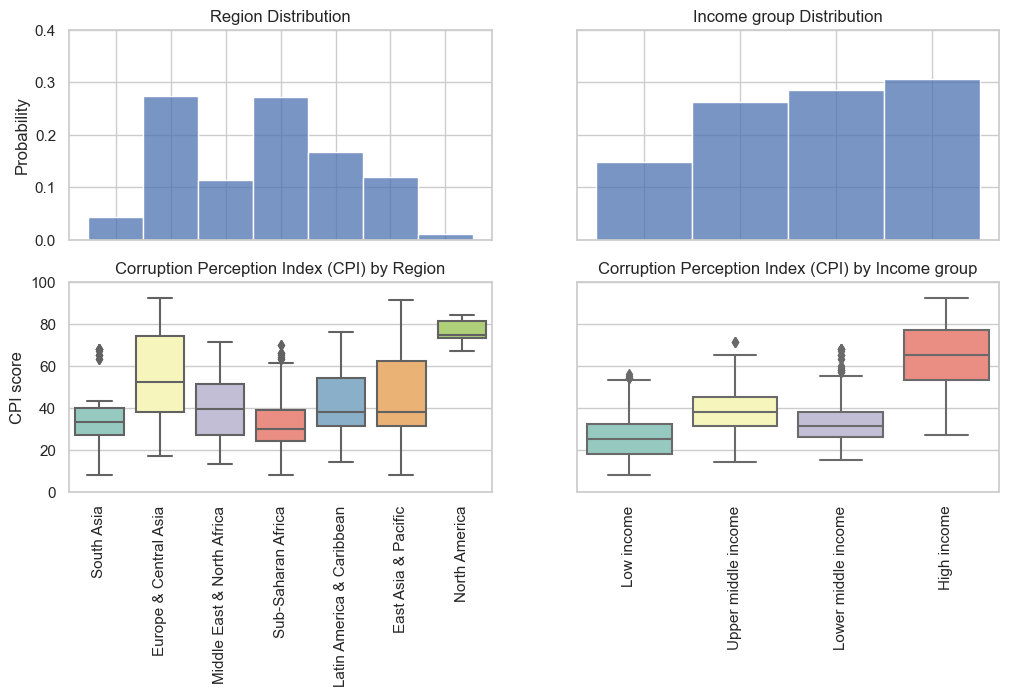

In [24]:
# View distribution of Region and Income group
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 6))

# flatten the axs array
axs = axs.flatten()

# Plot the histogram in the first subplot
sns.histplot(data=df, x='Region', kde=False, bins=40, stat="probability", ax=axs[0])
axs[0].set_title('Region Distribution')
axs[0].set_xticklabels([])
axs[0].set_xlabel(None)
axs[0].set_ylim(0, 0.4)

sns.histplot(data=df, x='Income group', kde=False, bins=40, stat="probability", ax=axs[1])
axs[1].set_title('Income group Distribution')
axs[1].set_xticklabels([])
axs[1].set_xlabel(None)
axs[1].set_ylim(0, 0.4)
axs[1].set_yticklabels([])
axs[1].set_ylabel(None)

# Plot the boxplot in the second subplot
sns.boxplot(x="Region", y="CPI score", data=df, palette="Set3", ax=axs[2])
axs[2].set_title('Corruption Perception Index (CPI) by Region')
axs[2].tick_params(axis='x', rotation=90)
axs[2].set_ylim(0, 100)
axs[2].set_xlabel(None)

# Plot the boxplot in the second subplot
sns.boxplot(x="Income group", y="CPI score", data=df, palette="Set3", ax=axs[3])
axs[3].set_title('Corruption Perception Index (CPI) by Income group')
axs[3].tick_params(axis='x', rotation=90)
axs[3].set_ylim(0, 100)
axs[3].set_yticklabels([])
axs[3].set_ylabel(None)
axs[3].set_xlabel(None)

# Display the figure
plt.show()


#### Feature correlation

With more than 1,400 indicators available, it is very likely that many of them are highly correlated with each other. We will need to identify and drop these some indicators from our analysis.


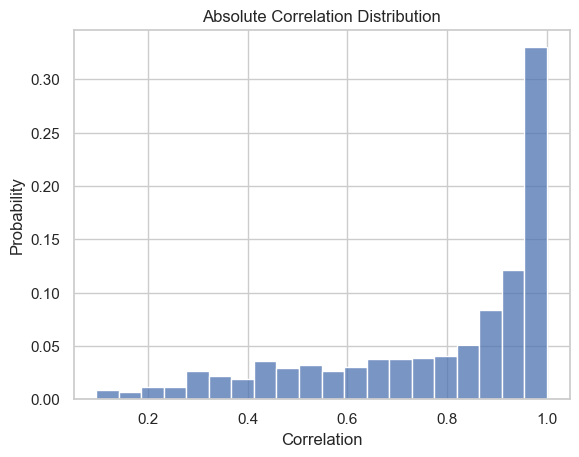

In [25]:
corr_matrix = df.drop(['Year','CPI score'],axis=1).corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

corr_stack = tri_df.stack().reset_index().sort_values(0, ascending=False)
corr_stack.rename(columns={'level_0':'Feature 1', 'level_1':'Feature 2', 0:'Correlation'}, inplace=True)
corr_stack = corr_stack[corr_stack['Feature 1'] != corr_stack['Feature 2']]
corr_stack.head(100)
max_corr = corr_stack.groupby('Feature 1').max().reset_index()

# display distribution of Correlation
sns.histplot(data=max_corr, x='Correlation', kde=False, bins=20, stat="probability")
plt.title('Absolute Correlation Distribution')
plt.show()

##### Selection of indicators using Variance Inflation Factor (VIF)

As expected, there is a high correlation between the indicators. We will need to drop some of them from our analysis to reduce multicollinearity.

We will use Variance InflationFactor (VIF) to identify indicators that are highly correlated with other indicators. 

The VIF measures the correlation between each predictor and all the other predictors in the model. It is used to identify the presence of collinearity in a multiple regression analysis. A VIF of 1 means that there is no correlation between a given predictor and any other predictor. The higher the VIF, the higher the correlation between the predictor and the other predictors.


In [26]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant to the independent variables
df = sm.add_constant(df)

# prepare data for training
X = df.drop(columns=['ISO3', 'Country Name', 'CPI score', 'Year', 'CPI score'])
y = df['CPI score']

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# get columns with numeric data types
numeric_features = X.select_dtypes(include=[np.number]).columns

# Fit the multiple regression model
model = sm.OLS(y, X[numeric_features]).fit()

# Calculate the VIF for each independent variable
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X[numeric_features].values, i) for i in range(X[numeric_features].shape[1])]
vif["features"] = numeric_features

# drop the features with highest VIF Factor
df.drop(vif[vif['VIF Factor'] > 200]['features'], axis=1, inplace=True)

In [27]:
threshold = .90
# Calculate the correlation matrix
corr_matrix = df.corr().abs()

# Create a mask to ignore self-
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)

# List of features to be removed
to_drop = []

# Iterate over the features
for column in tri_df.columns:
    if column not in to_drop :
        to_drop.extend(tri_df[column][tri_df[column] > threshold].index)

# Drop the features
df.drop(to_drop, axis=1, inplace=True)
print(f'Number of features left: {len(df.columns)}')

Number of features left: 191


##### Visualize the most correlated indicators

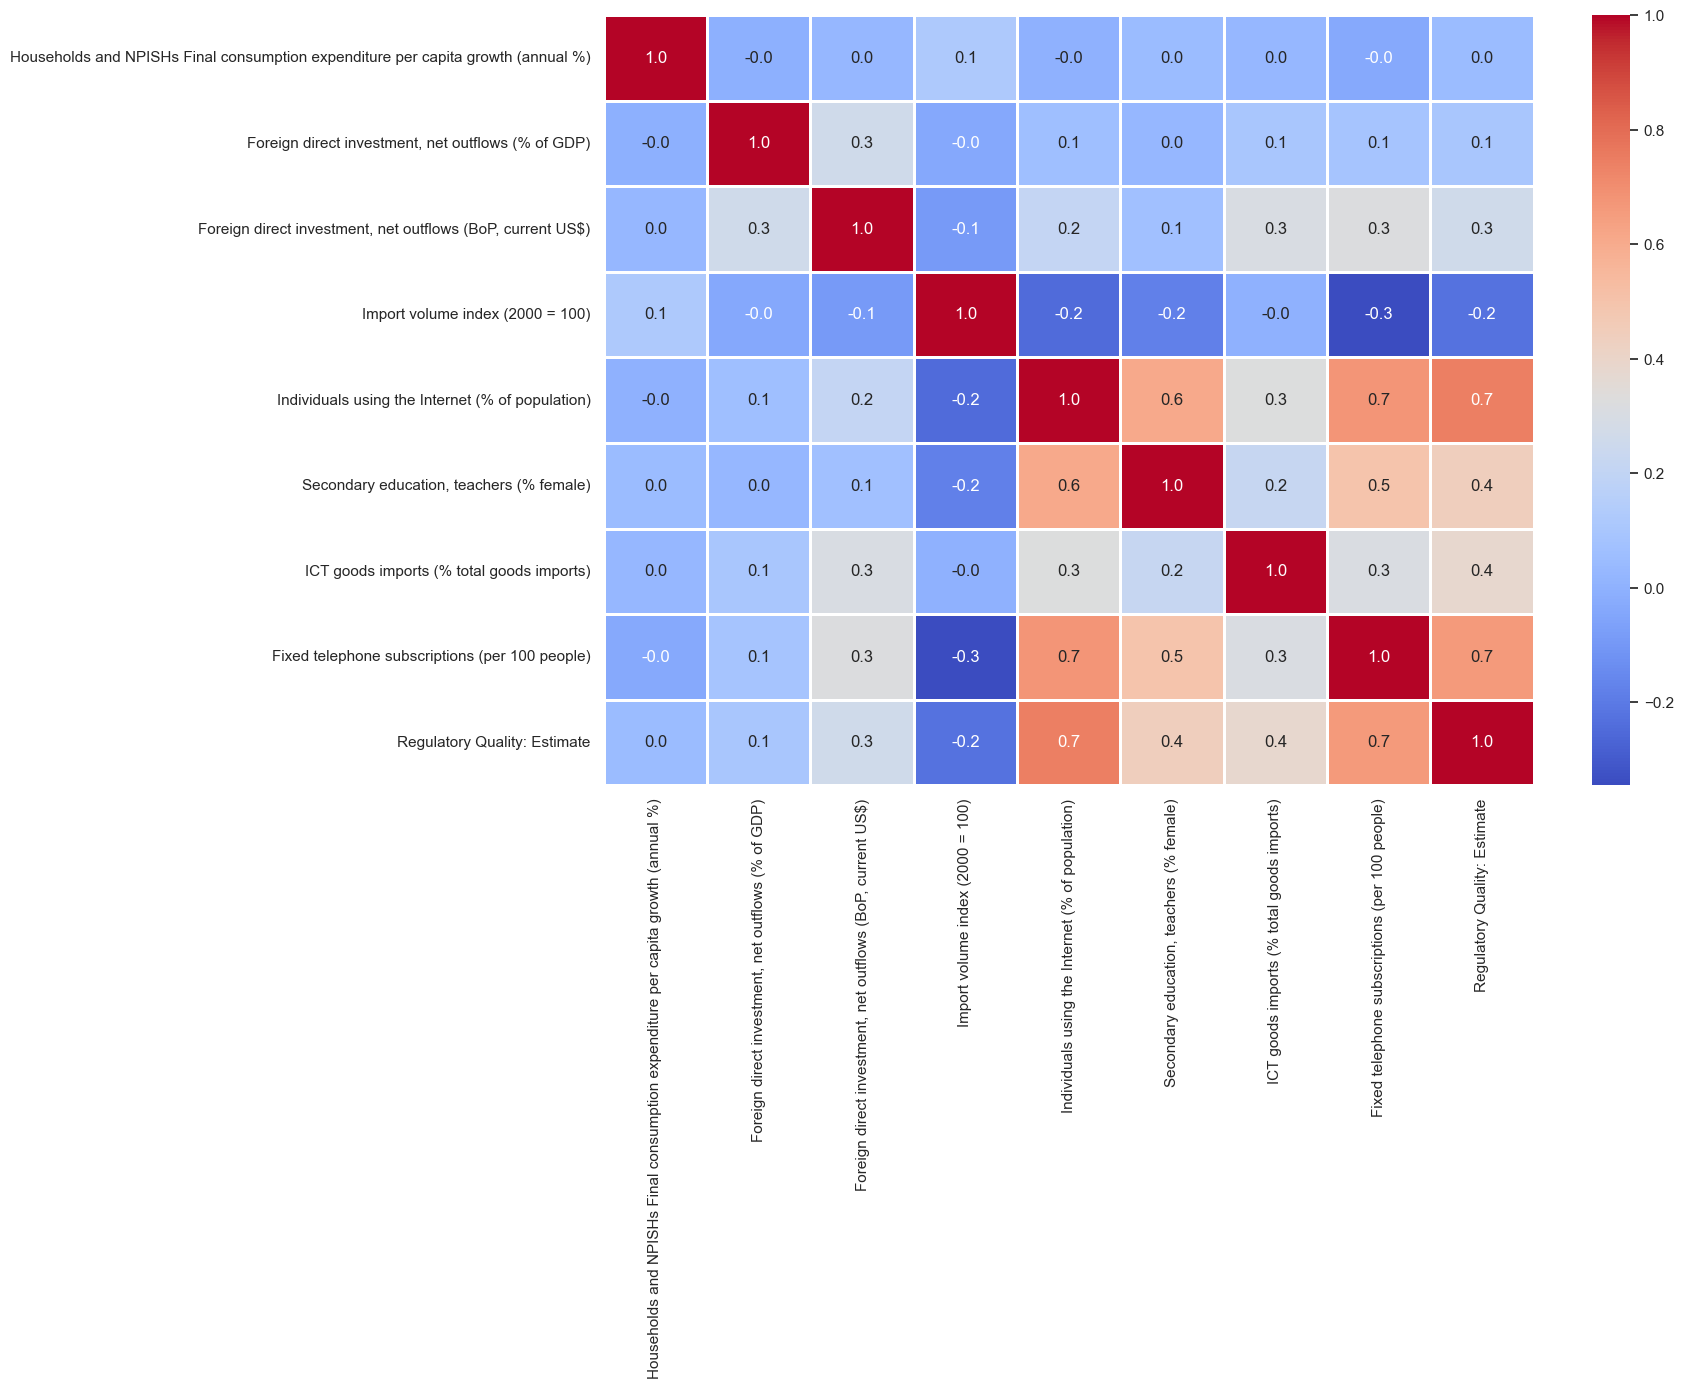

In [28]:
# Remaining features with highest correlation
corr_matrix = df.corr().abs()

threshold = threshold -.1
correlated_features = set()
correlation_matrix = df.drop(columns=['Year'],axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

correlation_matrix = df[correlated_features].corr()           

# draw the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.1f', linewidths=1)
plt.show()

#### Analyse Distribution and Check for outliers

We have to many indicators to analyse the distribution of each one of them. We will focus on the distribution of the indicators that are the most correlated with CPI score as they are likely to be the most relevant for our analysis.


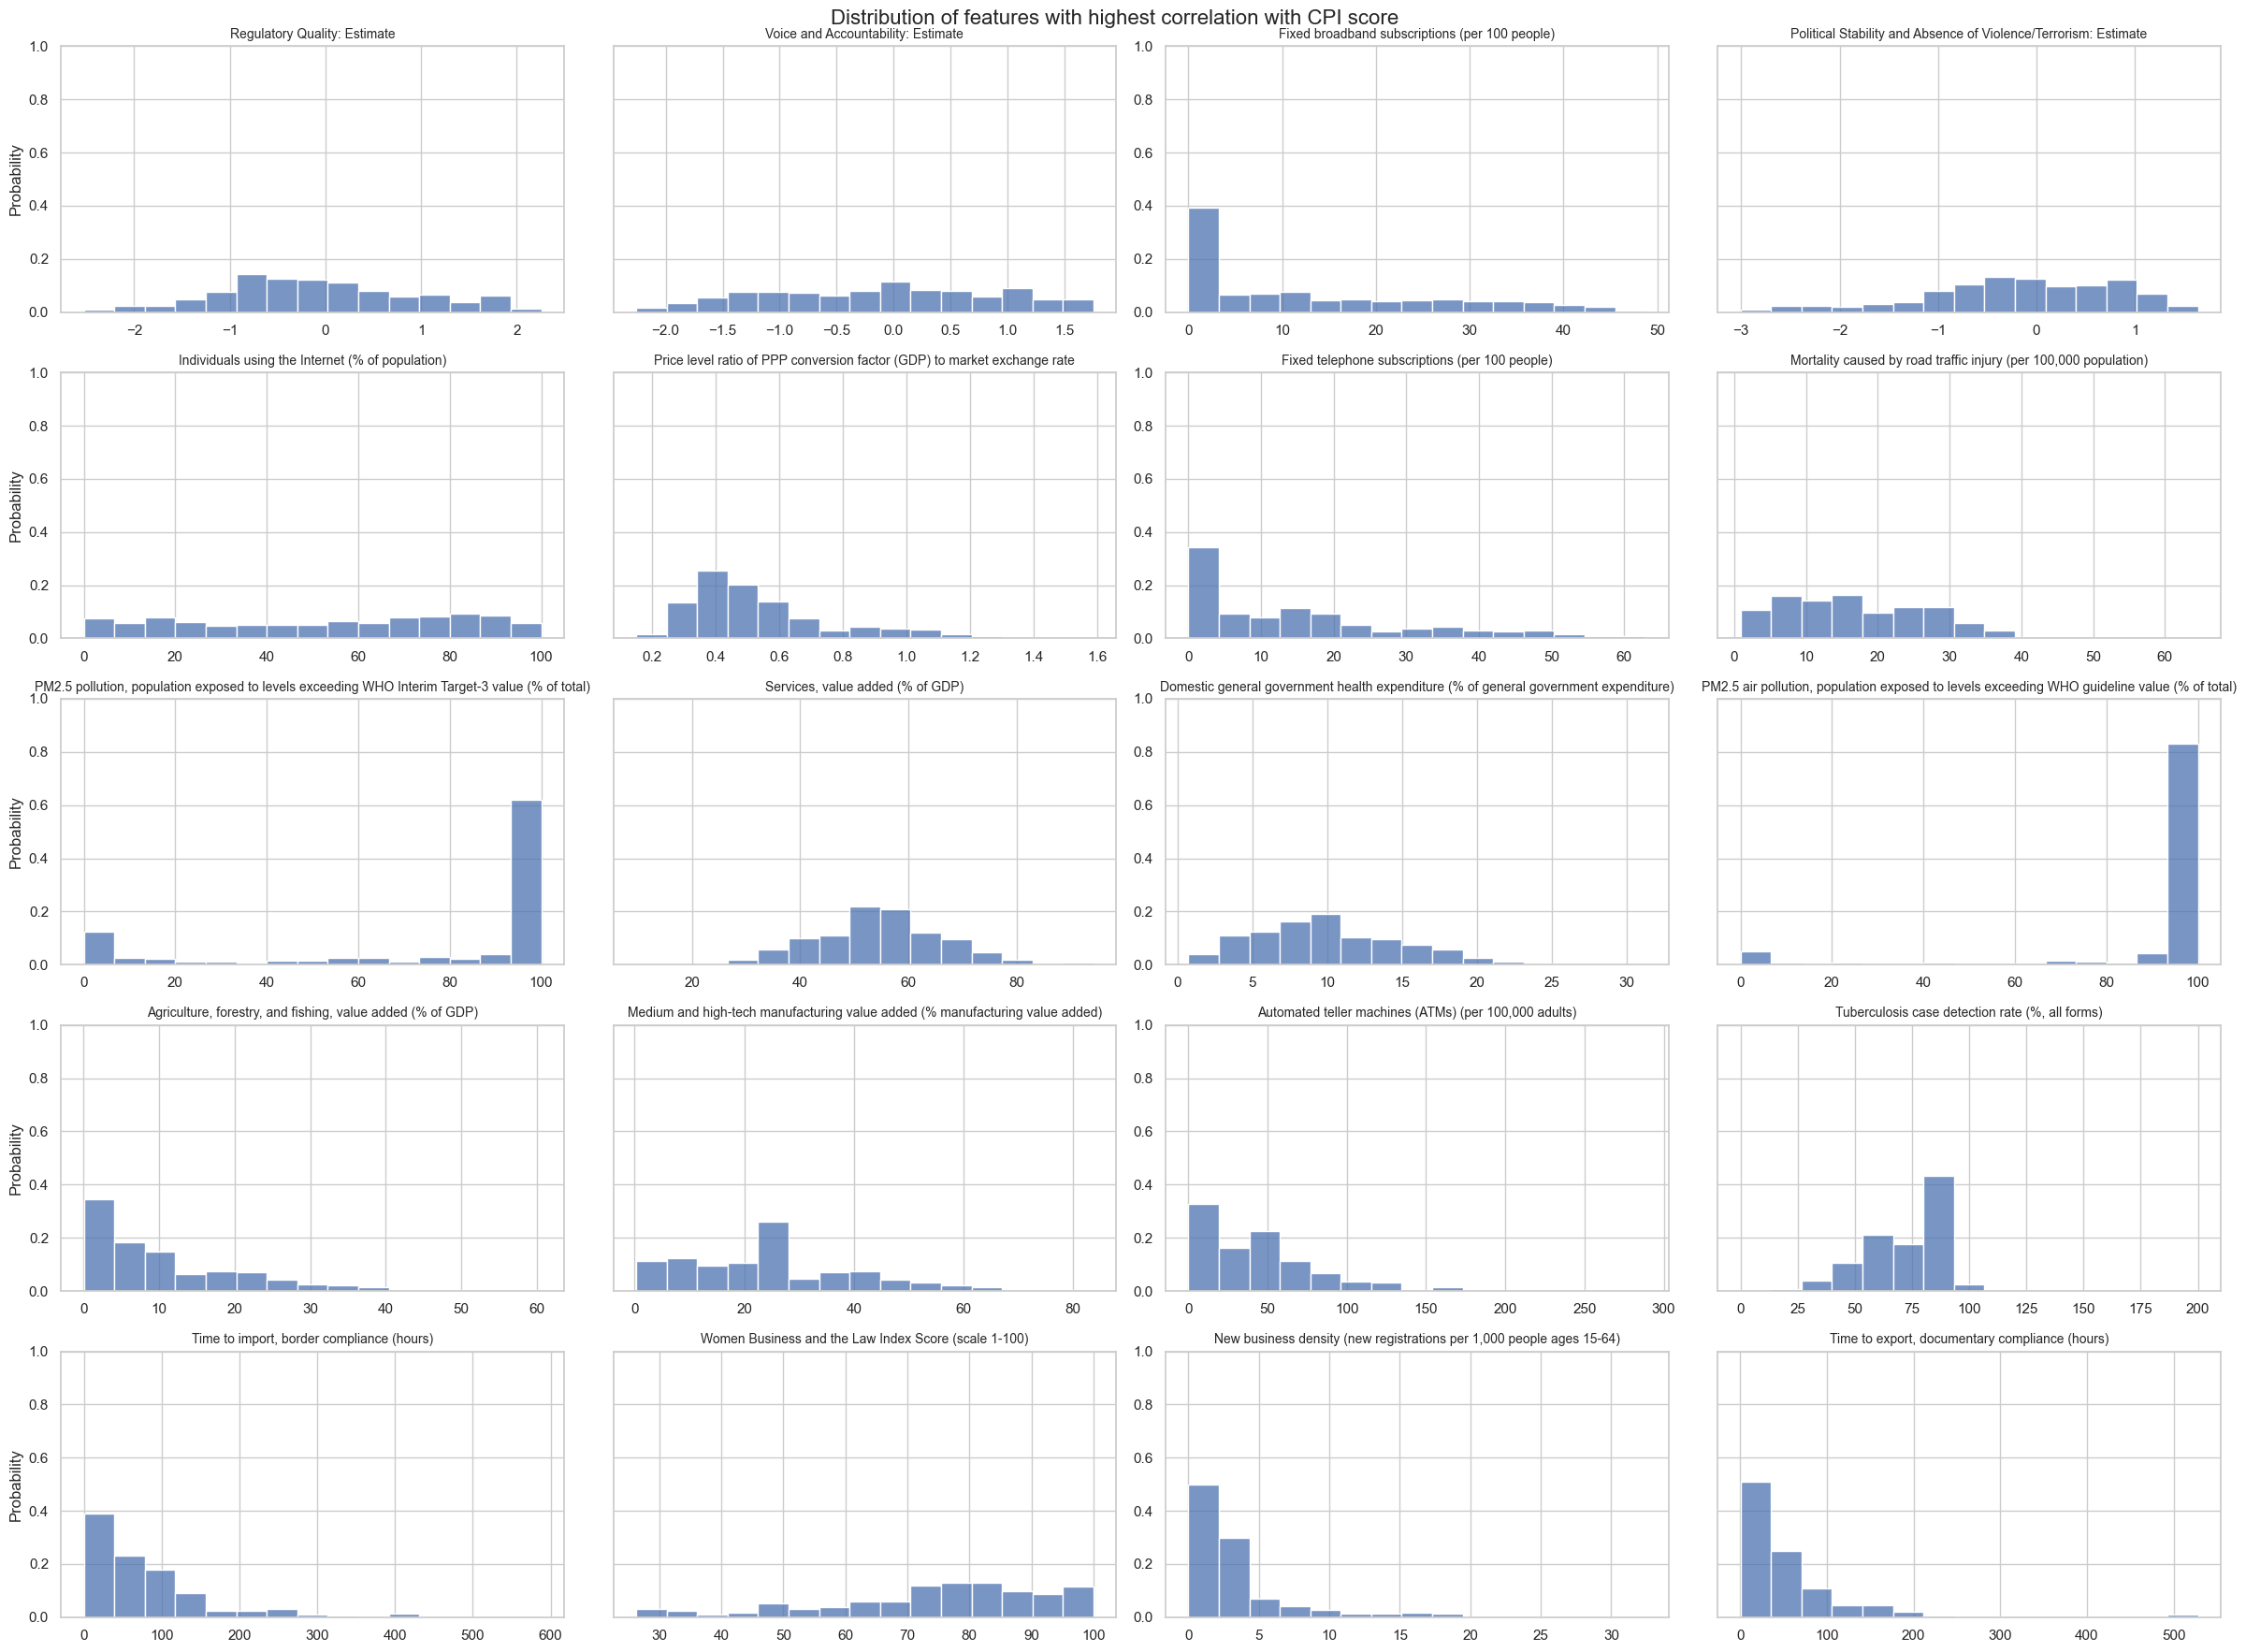

In [33]:
# get top 10 features with highest correlation between CPI score and features
correlation_matrix = df.corr().abs()
correlated_features = correlation_matrix['CPI score'].sort_values(ascending=False).iloc[1:21] # exclude CPI score (0)

# Create a grid of subplots
fig, axs = plt.subplots(5, 4, figsize=(24, 18))

# Flatten the 2D array of subplots into a 1D array
axs = axs.flatten()

# Loop over the columns and plot a histogram in each subplot
for i, col in enumerate(correlated_features.index):
    sns.histplot(df[col], ax=axs[i], bins=15, kde=False, stat='probability')
    axs[i].set_title(col, wrap=True, fontsize=10)
    if i%4 == 0 :
        axs[i].set_ylabel('Probability')
    else:
        axs[i].set_ylabel('')
    axs[i].set_xlabel('')
    axs[i].tick_params(left=False, labelleft=(i % 2 == 0))
    axs[i].set_ylim(0, 1)

# Remove the unused subplots
for i in range(len(correlated_features.index), len(axs)):
    axs[i].remove()

# add global title
fig.suptitle('Distribution of features with highest correlation with CPI score', fontsize=16)

# Adjust the spacing between subplots
fig.tight_layout()
plt.show()

## Modelling
#### Feature preprocessing

For our analysis, we will ignore the country, ISO3, region and year columns.
 
All the features are numerical. However, each feature has a very different distribution. We will need to scale and normalize the data before using it in our analysis.

In [34]:
# prepare data for training
X = df.drop(columns=['ISO3', 'Country Name', 'CPI score', 'Year', 'CPI score'])
y = df['CPI score']

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Preprocessing
categorical_features = ['Region']
ordinal_features = ['Income group']
income_ord = ['Low income', 'Lower middle income', 'Upper middle income', 'High income']
numeric_features = X.columns.drop(categorical_features + ordinal_features)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('ord', OrdinalEncoder(categories=[income_ord]), ordinal_features)],
    remainder='passthrough')


Mean squared error: 21.05
Coefficient of determination: 0.94
MAE: 3.67


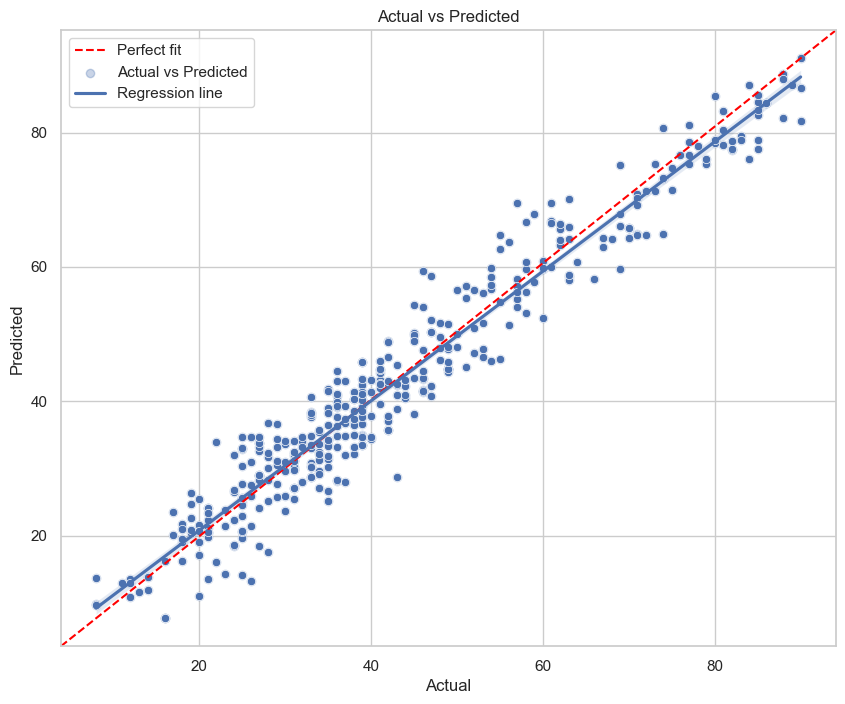

In [36]:
# create linear regression object
base_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# train the model using the training sets
base_model.fit(X_train, y_train)

# make predictions using the testing set
y_pred = base_model.predict(X_test)

# The mean squared error
print('Mean squared error: %.2f'
    % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
    % r2_score(y_test, y_pred))
# MAE
print('MAE: %.2f'
    % np.mean(np.abs(y_test - y_pred)))

# plot actual vs predicted with line of best fit
plt.figure(figsize=(10, 8))
# plot the line of perfect fit
ax = plt.gca()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red', ls='--')
# plot regression line
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3})
# add legend
ax.legend(['Perfect fit', 'Actual vs Predicted','Regression line'], loc='upper left')
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

#### Improvement and Fine-tuning the best model

- Defining the evaluation metrics to adusted R2. 

- Fine-tuning Gradient Boosting Regressor model hyper-parameters.

##### Defining evaluation metric to adjusted R2

The Adjusted R2 takes into account the number of predictors in the model, unlike the R2. It penalizes the addition of uninformative predictors, providing a more accurate measure of the goodness of fit when dealing with models with multiple correlated predictors.

In [37]:
# Custom scorer for adjusted R-squared
def adjusted_r2_scorer(y_true, y_pred, **kwargs):
    n = y_true.shape[0]
    p = kwargs.get('n_features')
    r2 = r2_score(y_true, y_pred)
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    return adjusted_r2

##### Testing multiple models and comparing their performance

In [38]:
# Create function to evaluate models using cross-validation and grid search
# models: dictionary of models to evaluate
# preprocessor: preprocessor object
# X_train, y_train, X_test, y_test: train and test data
# scoring: scoring metric
def evalRegressorModels(models, preprocessor, X_train, y_train, X_test, y_test, scoring='neg_mean_squared_error'):

    # create dataframe to capture model metrics
    metrics = []

    # loop through the regressors dictionary items
    for model_name, (model, params) in models.items():
        # Create grid search
        print(f'Running grid search for {model_name}')
        pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        # create a grid search object and fit it to the data using cross-validation
        grid = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1, scoring=scoring)

        # fit the grid search object to the training data
        grid.fit(X_train, y_train)

        results = grid.cv_results_
        # capture the best estimator and the best parameters
        best_model = grid.best_estimator_
        best_params = grid.best_params_

        # predict on the test data using the best estimator
        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)

        MSE_train = mean_squared_error(y_train, train_pred)
        MSE_test = mean_squared_error(y_test, test_pred)
        R2_train = r2_score(y_train, train_pred)
        R2_test = r2_score(y_test, test_pred)
        MAE_train = mean_absolute_error(y_train, train_pred)
        MAE_test = mean_absolute_error(y_test, test_pred)
        score_train = best_model.score(X_train, y_train)
        score_test = best_model.score(X_test, y_test)

        # training time taken
        train_time = grid.cv_results_.get('mean_fit_time').mean()

        # append the model metrics to the model_metrics list
        metrics.append([model_name, best_params, train_time, MSE_train, MSE_test ,MAE_train, MAE_test, R2_train, R2_test, score_train, score_test , best_model, results])

    # create a dataframe from the model_metrics list
    return pd.DataFrame(metrics, columns=['model_name', 'best_params', 'train_time', 'MSE_train', 'MSE_test' ,'MAE_train', 'MAE_test', 'R2_train', 'R2_test', 'score_train', 'score_test' , 'model', 'results'])

In [39]:
numeric_features = X.columns.drop(categorical_features + ordinal_features)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('ord', OrdinalEncoder(categories=[income_ord]), ordinal_features)],
    remainder='passthrough')

# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

regressors = {
    'LinearRegression': (LinearRegression(),
                        {'preprocessor__num': [RobustScaler()]}),
    'Ridge': (Ridge(),
            {'preprocessor__num': [RobustScaler()],
             'model__alpha': np.logspace(-3, 3, 7)}),
    'Lasso': (Lasso(max_iter=10000),
            {'preprocessor__num': [RobustScaler()],
            'model__alpha': np.logspace(-3, 3, 7)}),
    'ElasticNet': (ElasticNet(max_iter=10000),
                {'preprocessor__num': [RobustScaler()],
                'model__alpha': np.logspace(-3, 3, 7),
                'model__l1_ratio': np.linspace(0.1, 0.9, 9)}),
    'RandomForestRegressor': (RandomForestRegressor(),
                            {'preprocessor__num': [RobustScaler()],
                            'model__n_estimators': [10, 50, 100,200],
                            'model__max_depth': [None, 5, 10, 20, 50],
                            'model__max_features': ['sqrt', 'log2']}),
    'GradientBoostingRegressor': (GradientBoostingRegressor(),
                                {'preprocessor__num': [RobustScaler()],
                                'model__n_estimators': [10, 50, 100,200],
                                'model__max_depth': [None, 5, 10, 20, 50],
                                'model__max_features': ['sqrt', 'log2']}),
    'XGBRegressor': (XGBRegressor(),
                    {'preprocessor__num': [RobustScaler()],
                    'model__n_estimators': [10, 50, 100,200],
                    'model__max_depth': [None, 5, 10, 20, 50]}),
    'LGBMRegressor': (LGBMRegressor(),
                    {'preprocessor__num': [RobustScaler()],
                    'model__n_estimators': [10, 50, 100,200],
                    'model__max_depth': [None, 5, 10, 20, 50]}),
    'CatBoostRegressor': (CatBoostRegressor(verbose=False),
                        {'preprocessor__num': [RobustScaler()],
                        'model__n_estimators': [10, 50, 100,200]})
}

n_features = X.shape[1]
adjusted_r2 = make_scorer(adjusted_r2_scorer, greater_is_better=True, n_features=n_features)

model_metrics = evalRegressorModels(regressors, preprocessor, X_train, y_train, X_test, y_test,
                                    scoring=adjusted_r2)
model_metrics[['model_name', 'best_params', 'train_time', 'MSE_train', 'MSE_test', 'MAE_train' ,'MAE_test', 'R2_test', 'score_train', 'score_test' ]]

Running grid search for LinearRegression


Running grid search for Ridge
Running grid search for Lasso
Running grid search for ElasticNet
Running grid search for RandomForestRegressor
Running grid search for GradientBoostingRegressor
Running grid search for XGBRegressor
Running grid search for LGBMRegressor
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001807 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41304
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 41314
[LightGBM] [Info] Number of data points in the train set: 1232, number of used features: 191
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Num

,model_name,best_params,train_time,MSE_train,MSE_test,MAE_train,MAE_test,R2_test,score_train,score_test
0,LinearRegression,{'preprocessor__num': RobustScaler()},0.038904,1.542922e+01,21.047661,3.084328e+00,3.665943,0.943260,0.958669,0.943260
1,Ridge,"{'model__alpha': 1000.0, 'preprocessor__num': ...",0.035230,3.837927e+01,39.022349,4.891379e+00,5.030926,0.894805,0.897192,0.894805
2,Lasso,"{'model__alpha': 0.1, 'preprocessor__num': Rob...",0.138373,2.087100e+01,25.084600,3.533644e+00,3.958167,0.932378,0.944092,0.932378
3,ElasticNet,"{'model__alpha': 0.1, 'model__l1_ratio': 0.9, ...",0.138239,2.091734e+01,25.016327,3.548499e+00,3.966232,0.932562,0.943968,0.932562
4,RandomForestRegressor,"{'model__max_depth': None, 'model__max_feature...",0.468991,9.181726e-01,5.301468,7.187500e-01,1.777468,0.985708,0.997540,0.985708
5,GradientBoostingRegressor,"{'model__max_depth': None, 'model__max_feature...",0.680810,3.756163e-16,4.550283,1.577499e-08,1.591591,0.987734,1.000000,0.987734
6,XGBRegressor,"{'model__max_depth': 5, 'model__n_estimators':...",3.559066,8.760186e-03,6.069006,6.581718e-02,1.919917,0.983639,0.999977,0.983639
7,LGBMRegressor,"{'model__max_depth': 10, 'model__n_estimators'...",0.660322,1.336431e-01,5.886138,2.479573e-01,1.753871,0.984132,0.999642,0.984132
8,CatBoostRegressor,"{'model__n_estimators': 200, 'preprocessor__nu...",2.938456,1.009941e+00,6.515665,7.982404e-01,1.908313,0.982435,0.997295,0.982435


##### Comparing the performance of the models

In [40]:
model_metrics['Overfitting Ratio'] = 1 - (model_metrics['R2_test'] / model_metrics['R2_train'])

fig = px.scatter(model_metrics, x="train_time", y="score_test", size="Overfitting Ratio", color="model_name",
                    hover_name="model_name", log_x=True, size_max=50,
                    width=600, height=400, title='Model performance vs. time to train')
fig.update_layout(
    xaxis_title="Time to train (seconds)",
    yaxis_title="Test Adjusted-R2",
    legend_title="Model"
)
fig.add_annotation(
    x=-0.3,
    y=1,
    text="Bubble size represents overfitting ratio",
    showarrow=False
)
fig.write_image("images/ModelPerf.png")
fig.show()

The best model is `GradientBoostingRegressor` as it combines the best performance with the lowest overfitting as well as a limited training time.

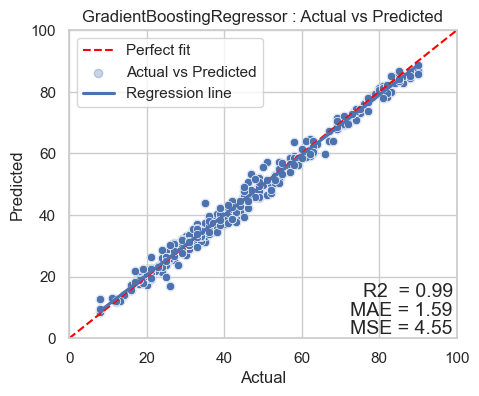

In [41]:
bestModelIndex = 5
y_pred = model_metrics['model'][bestModelIndex].predict(X_test)
model_name = model_metrics['model_name'][bestModelIndex]

# calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = np.mean(np.abs(y_test - y_pred))

# plot actual vs predicted with line of best fit
plt.figure(figsize=(5, 4))
# plot the line of perfect fit
ax = plt.gca()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red', ls='--')
# plot regression line
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3})
# add legend
ax.legend(['Perfect fit', 'Actual vs Predicted','Regression line'], loc='upper left')
sns.scatterplot(x=y_test, y=y_pred)
# add metrics to plot
plt.text(99, 0, 'MSE = {:.2f}'.format(mse), fontsize=14, ha='right', va='bottom')
plt.text(99, 6, 'MAE = {:.2f}'.format(mae), fontsize=14, ha='right', va='bottom')
plt.text(99, 12, 'R2  = {:.2f}'.format(r2), fontsize=14, ha='right', va='bottom')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(model_name + ' : Actual vs Predicted')
plt.savefig("images/ActualVsPredicted.png")
plt.show()

##### Fine-tuning Gradient Boosting Regressor model hyper-parameters

We will use the `GridSearchCV` function to find the best hyper-parameters for our model. We will use the following hyper-parameters:

- `n_estimators`: the number of boosting stages to perform.
- `max_depth`: the maximum depth of the individual regression estimators.
- `learning_rate`: learning rate shrinks the contribution of each tree by `learning_rate`.
- `loss`: loss function to be optimized.

We will compare StandardScaler, RobustScaler and PowerTransformer to normalize the data.


In [42]:
pipe = Pipeline([
            ('preprocessor', preprocessor),
            ('model', GradientBoostingRegressor(max_features='sqrt', n_estimators=200, random_state=42))
        ])

param_grid = {
    'preprocessor__num': [StandardScaler(),RobustScaler(),PowerTransformer()],
    'model__max_depth': [None, 10, 20],
    'model__learning_rate': [0.01, 0.1, 1],
    'model__loss': ['squared_error', 'quantile', 'huber']
}

n_features = X.shape[1]
adjusted_r2 = make_scorer(adjusted_r2_scorer, greater_is_better=True, n_features=n_features)

grid = GridSearchCV(pipe, param_grid, cv=5, scoring=adjusted_r2, n_jobs=-1, verbose=0)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['const', 'Adjusted savings: carbon dioxide damage (% of GNI)',
       'Adjusted savings: consumption of fixed capital (% of GNI)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Adjusted savings: mineral depletion (current US$)',
       'Ad...
                                        GradientBoostingRegressor(max_features='sqrt',
                                                                  n_estimators=200,
                                                                  random_state=42))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1, 1],
                         'model__loss': ['squared_error', 'quantile', 'huber'],
                         'model__max_depth': [None, 10, 20],
                         'preprocessor__num': [StandardScaler(), RobustScaler(),
                                               PowerTransformer()]},
             scoring=make_scorer(adjusted_r2_scorer, n_features=187))

In [43]:
# capture the best estimator and the best parameters
best_params = grid.best_params_
best_model = grid.best_estimator_
results = grid.cv_results_

for param_name in sorted(best_params.keys()):
    print("%s: %r" % (param_name, best_params[param_name]))

model__learning_rate: 0.1
model__loss: 'huber'
model__max_depth: 20
preprocessor__num: StandardScaler()


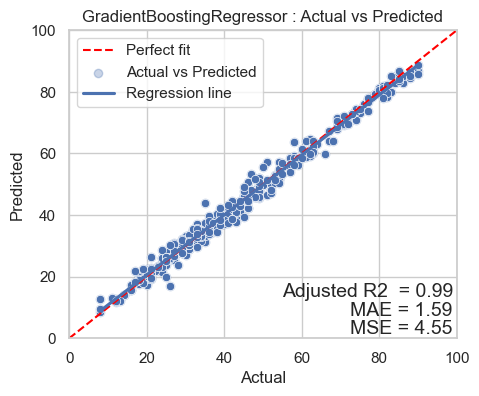

In [44]:
# predict on the test data using the best estimator
train_pred = best_model.predict(X_train)
test_pred = best_model.predict(X_test)

# calculate metrics
mse = mean_squared_error(y_test, y_pred)
adjusted_r2 = best_model.score(X_test, y_test)
mae = np.mean(np.abs(y_test - y_pred))

# plot actual vs predicted with line of best fit
plt.figure(figsize=(5, 4))
# plot the line of perfect fit
ax = plt.gca()
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='red', ls='--')
# plot regression line
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3})
# add legend
ax.legend(['Perfect fit', 'Actual vs Predicted','Regression line'], loc='upper left')
sns.scatterplot(x=y_test, y=y_pred)
# add metrics to plot
plt.text(99, 0, 'MSE = {:.2f}'.format(mse), fontsize=14, ha='right', va='bottom')
plt.text(99, 6, 'MAE = {:.2f}'.format(mae), fontsize=14, ha='right', va='bottom')
plt.text(99, 12, 'Adjusted R2  = {:.2f}'.format(adjusted_r2), fontsize=14, ha='right', va='bottom')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(model_name + ' : Actual vs Predicted')
plt.savefig("images/ActualVsPredicted.png")
plt.show()

##### Model Description

The prediction model selected for this task is a pipeline composed of preprocessing steps and a Gradient Boosting Regressor for the prediction task. Below is a breakdown of each component of the pipeline:

**Preprocessing:** Handled by `ColumnTransformer` that applies different preprocessing steps for different types of features:

  - `StandardScaler`: Applied to numerical features to standardize them to have mean 0 and variance 1.
  - `OneHotEncoder`: Converts categorical features into a one-hot vector. Applied to the 'Region' feature.
  - `OrdinalEncoder`: Encodes ordinal features as integers. It is applied to the 'Income group' feature with a specified order.


**Regressor:** `GradientBoostingRegressor` is used in the pipeline with the following settings **Hyperparameters**:

  - `max_features='sqrt'`: Sets the number of features to consider when looking for the best split to the square root of the total number of features.
  - `n_estimators=200`: Sets the number of boosting stages to perform.
  - `model__learning_rate: 0.1`: Controls the contribution of each tree in the ensemble.
  - `model__loss: 'squared_error'`: Sets the loss function to be optimized.
  - `model__max_depth: 20`: Sets the maximum depth of the individual regression estimators.




#### Feature Importance

We will use the `feature_importances` to identify the most important features for our model.

In [51]:
def plot_feature_importance(X_test, result, nb_features):
    # create dataframe of feature importance 
    feature_names = X_test.columns
    importance = result.importances_mean
    feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
    feature_importance.sort_values(by='importance', ascending=False, inplace=True)

    # plot top features by importance
    plt.figure(figsize=(16, 12))
    sns.barplot(x='importance', y='feature', data=feature_importance.iloc[:nb_features])
    plt.xlabel('Importance')
    plt.ylabel('Feature', wrap=True,  ha='right')
    plt.title('Feature importance')
    plt.savefig("images/FeatureImportance.png")
    plt.show()

    # print the top features
    for i in range(nb_features):
        print(str(i+1) + '. ' + feature_importance.iloc[i].feature)

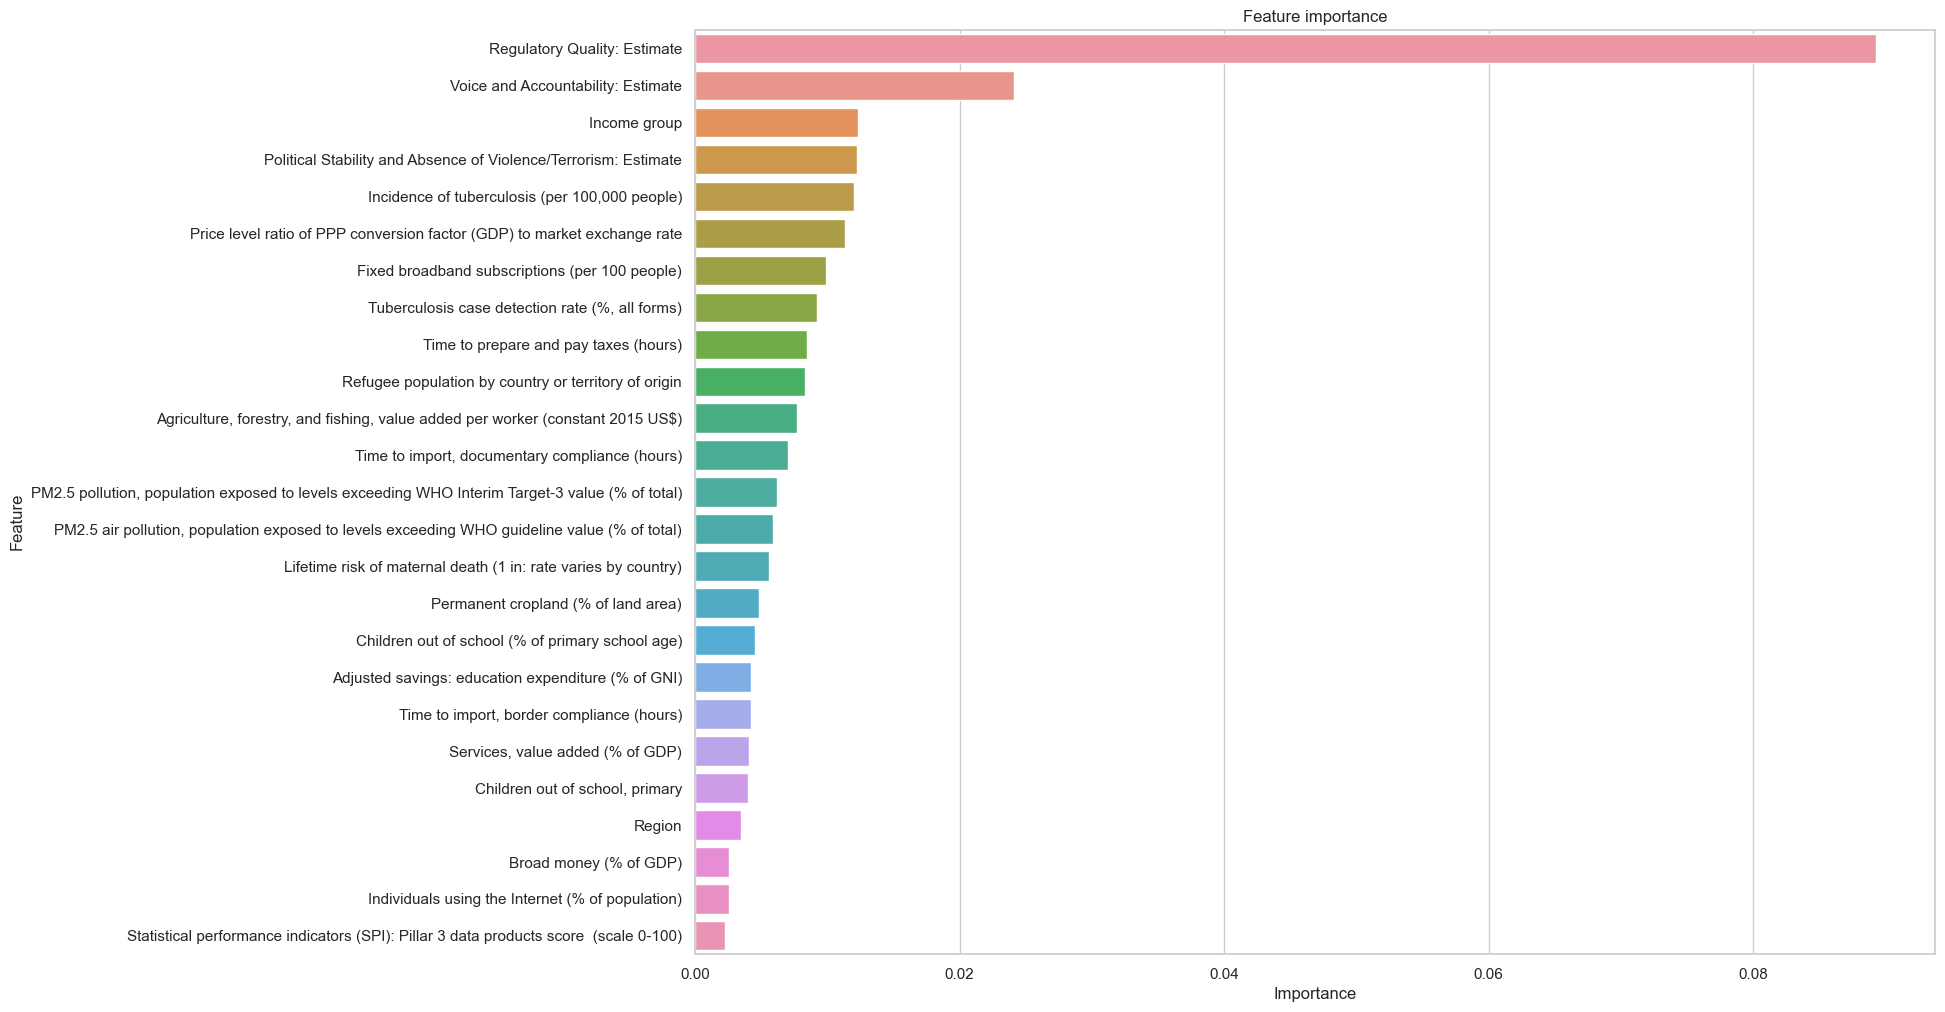

1. Regulatory Quality: Estimate
2. Voice and Accountability: Estimate
3. Income group
4. Political Stability and Absence of Violence/Terrorism: Estimate
5. Incidence of tuberculosis (per 100,000 people)
6. Price level ratio of PPP conversion factor (GDP) to market exchange rate
7. Fixed broadband subscriptions (per 100 people)
8. Tuberculosis case detection rate (%, all forms)
9. Time to prepare and pay taxes (hours)
10. Refugee population by country or territory of origin
11. Agriculture, forestry, and fishing, value added per worker (constant 2015 US$)
12. Time to import, documentary compliance (hours)
13. PM2.5 pollution, population exposed to levels exceeding WHO Interim Target-3 value (% of total)
14. PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)
15. Lifetime risk of maternal death (1 in: rate varies by country)
16. Permanent cropland (% of land area)
17. Children out of school (% of primary school age)
18. Adjusted savings: education

In [52]:
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)
plot_feature_importance(X_test, result, 25)

#### Conclusions
Conclusions can be found in [Readme.md](README.md) file.


